# SOMBR: Using SOM to Triage Software Bug Reports

## Setup

### Import package dependencies

In [1]:
import os
import re
import sys
import sqlite3
import pandas as pd

# from tqdm import tqdm
from tqdm.notebook import trange, tqdm
 
 

In [2]:
from sklearn.datasets import fetch_20newsgroups
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

# nltk.download('punkt')

In [3]:
from collections import Counter
import numpy as np
import statistics 


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

sns.set(style="white")
sns.set_context("paper")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = ['cmr10', 'sans-serif']
plt.rcParams['axes.formatter.use_mathtext'] = True


### Define variables

In [5]:
BR_QUERY_ALL = """SELECT * from issue"""

KEEP_ISSUE_COLS = ['issue_id', 'type', 'created_date', 'resolved_date', 'summary', 'description', 'priority', 'status', 'resolution', 'assignee_username']
KEEP_RESOLUTION = ['Done', 'Duplicate', 'Fixed', 'Resolved']
KEEP_STATUS = ['Resolved', 'Closed']
KEEP_TYPE = ['Bug']


THRESHOLD_CORPUS_SIZE = 2500

KEEP_DB_COLS_QUERY = """
SELECT 
{} 
from issue
""".format((",\n").join(KEEP_ISSUE_COLS))

In [6]:
db_path = "./db/"
db_list = ['railo.sqlite3',
 'seam2.sqlite3',
 'kafka.sqlite3',
 'resteasy.sqlite3',
 'jboss-tm.sqlite3',
 'hbase.sqlite3',
 'hive.sqlite3',
 'hornetq.sqlite3',
 'zookeeper.sqlite3',
 'jbpm.sqlite3',
 'teiid.sqlite3',
 'izpack.sqlite3',
 'weld.sqlite3',
 'log4j2.sqlite3',
 'lucene.sqlite3',
 'infinispan.sqlite3',
 'hadoop.sqlite3',
 'flink.sqlite3',
 'errai.sqlite3',
 'axis2.sqlite3',
 'jbehave.sqlite3',
 'groovy.sqlite3',
 'pig.sqlite3',
 'cassandra.sqlite3',
 'archiva.sqlite3',
 'drools.sqlite3',
 'derby.sqlite3',
 'keycloak.sqlite3',
 'hibernate.sqlite3',
 'switchyard.sqlite3',
 'maven.sqlite3',
 'spark.sqlite3']

db_list.sort()
db_names = [i.split(".")[0] for i in db_list]


## Extract text from DB

### Utility Functions

In [8]:
def remove_digits(t):
    t = re.sub(r'\d+', '', t)
    t = re.sub(' +', ' ', t)
    return t.strip()

def replace_symbols(t):    
    t = ''.join([re.sub(r'[^A-Za-z0-9 ]+',' ',t)])
    t = re.sub(' +', ' ', t)
    return t.strip()

def truncate_sentence(s, l=300):
    ts = " ".join(s.split(" ")[:l])    
    return ts

def baseline_prep(t):
    tokens = " ".join(word_tokenize(t))    
    tokens = remove_digits(tokens)
    tokens = replace_symbols(tokens)
    tokens = truncate_sentence(tokens)
    tokens = re.sub(' +', ' ', tokens)
    
    return tokens.strip()

### Filter data

In [10]:
def get_filtered_csv(db_list, db_path_base, csv_path_base, csv_filtered_full_path, csv_filtered_path):
    f_counter = {}
    f_counts = {}
    

    for db_i in tqdm(db_list):
        db_path = os.path.join(db_path_base, db_i)
        
        con = sqlite3.connect(db_path)
        cur = con.cursor()

        db_name = db_i.split(".")[0]
        df_star = pd.read_sql_query(BR_QUERY_ALL, con)

        df_star.sort_values(by='resolved_date', inplace=True)
        
        df_star['isbug']          = df_star.apply(lambda row: (1 if (row['type']=='Bug') else 0), axis=1 )
        df_star['statusdone']     = df_star.apply(lambda row: (1 if (row['status'] in KEEP_STATUS) else 0), axis=1 )
        df_star['resolutiondone'] = df_star.apply(lambda row: (1 if (row['resolution'] in KEEP_RESOLUTION) else 0), axis=1 )
        df_star['hasassigned']    = (~df_star['assignee_username'].isna()).astype(int)
        
        df_filt = df_star[(df_star['isbug']==1) & 
                (df_star['statusdone']==1) &
                (df_star['resolutiondone']==1) & 
                (df_star['hasassigned']==1)
               ]
        
        df_trunc = df_filt.copy()
        df_trunc['summary'] = df_trunc['summary'].apply(lambda x: baseline_prep(x))
        df_trunc.replace('',np.nan, inplace=True)
        df_trunc.dropna(subset=KEEP_ISSUE_COLS, inplace=True)


        if df_trunc.shape[0] > THRESHOLD_CORPUS_SIZE:
            ## Keep all rows
            csv_name = db_name + "_issue.csv"

            csv_path_b = os.path.join(csv_path_base, csv_name)
            df_star[KEEP_ISSUE_COLS].to_csv(csv_path_b, index=False)
            
            ## Keep filtered rows
            csv_name = db_name + "_filt_full.csv"

            csv_path_f = os.path.join(csv_filtered_full_path, csv_name)
            df_filt[KEEP_ISSUE_COLS].to_csv(csv_path_f, index=False)
            
            ## Keep filtered rows, truncated + baseline prep
            
            csv_name = db_name + "_filtered.csv"

            csv_path_t = os.path.join(csv_filtered_path, csv_name)
            df_trunc[KEEP_ISSUE_COLS].to_csv(csv_path_t, index=False)


            f_counter[db_name] = df_trunc[KEEP_ISSUE_COLS]
    
    return f_counter





In [11]:
db_path = "./db"
csv_path_base = "./csv/DB_extract"
csv_filtered_path = "./csv/DB_filtered"
csv_filtered_full_path = "./csv/DB_filtered_full"
filtered_csv = get_filtered_csv(db_list, db_path, csv_path_base, csv_filtered_full_path, csv_filtered_path)

  0%|          | 0/32 [00:00<?, ?it/s]

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder


In [13]:
def split_and_label_df(df, xcol, ycol):
    X = df[[xcol]]
    y = df[ycol]
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        shuffle=False,
                                                        test_size=.7, 
                                                        random_state=0)
    
    oe = OrdinalEncoder(handle_unknown='use_encoded_value',
                    unknown_value=-1)
    
    oe.fit(np.array(y_train).reshape(-1,1))
    
    y_train_encoded = oe.transform(np.array(y_train).reshape(-1,1))
    y_test_encoded  = oe.transform(np.array(y_test).reshape(-1,1))

    return X_train, X_test, y_train_encoded, y_test_encoded



In [14]:
filtered_csv_list = list(filtered_csv.keys())

In [15]:
groovy = filtered_csv['groovy'].sort_values(by='resolved_date')[KEEP_ISSUE_COLS].copy()
groovy.reset_index(drop=True, inplace=True)
groovy.head()

,issue_id,type,created_date,resolved_date,summary,description,priority,status,resolution,assignee_username
0,GROOVY-16,Bug,2003-10-01T13:21:47Z,2003-10-05T18:55:09Z,Support closures with no parameters,We need to support closures with no parameters...,Major,Closed,Fixed,bob
1,GROOVY-20,Bug,2003-10-02T05:58:07Z,2003-10-05T20:05:22Z,allow package to be optional,"The package statement should be optional, defa...",Major,Closed,Fixed,bob
2,GROOVY-19,Bug,2003-10-02T05:57:58Z,2003-10-07T17:26:39Z,package should be optional in a Groovy class,Right now the package statement is mandatory. ...,Minor,Closed,Duplicate,bob
3,GROOVY-40,Bug,2003-10-28T23:22:40Z,2003-10-31T12:59:44Z,Allow class to be used as a special variable i...,I'd like 'class' to be a special variable like...,Major,Closed,Fixed,bob
4,GROOVY-47,Bug,2003-11-03T02:23:26Z,2003-11-03T09:28:23Z,Allow as a first character of a line to mean a...,To be able to run nice shell scripts like this...,Major,Closed,Fixed,bob


In [16]:
filtered_csv_list

['cassandra',
 'groovy',
 'hadoop',
 'hbase',
 'hibernate',
 'hive',
 'infinispan',
 'jbpm',
 'lucene',
 'spark']

## Get Corpus Stats

In [17]:
filtered_csv.keys()

dict_keys(['cassandra', 'groovy', 'hadoop', 'hbase', 'hibernate', 'hive', 'infinispan', 'jbpm', 'lucene', 'spark'])

In [18]:
filtered_csv['lucene'][['assignee_username']].groupby(['assignee_username']).value_counts().reset_index()['count'].describe()

count     80.000000
mean      47.787500
std       84.769784
min        1.000000
25%        2.000000
50%       14.500000
75%       50.750000
max      479.000000
Name: count, dtype: float64

In [19]:
pd.DataFrame(filtered_csv['lucene'][['assignee_username']].groupby(['assignee_username']).value_counts().values).describe()

,0
count,80.000000
mean,47.787500
std,84.769784
min,1.000000
25%,2.000000
50%,14.500000
75%,50.750000
max,479.000000


In [20]:
n_targets = []
targetcount_mean = []
targetcount_median = []
desc_cols = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
target_counts = {}
corpus_stats = pd.DataFrame(columns=desc_cols)

for corpus_name in filtered_csv.keys():
    corpus = filtered_csv[corpus_name].copy()
    user_counts = pd.DataFrame(corpus[['assignee_username']].groupby(['assignee_username']).value_counts().values)
    corpus_stats = pd.concat([corpus_stats, 
                              user_counts.describe().rename(columns={0:corpus_name}).T
                             ],
                             axis=0)
    
    n_targets.append(corpus[['assignee_username']].nunique().values[0])
    counts = Counter(corpus['assignee_username'])
    targetcount_mean.append(statistics.mean(counts.values()))
    targetcount_median.append(statistics.median(counts.values()))
    target_counts[corpus_name] = list(counts.values())
    
    

corpus_stats = pd.concat([corpus_stats.iloc[:,[3,-1]], 
                       pd.DataFrame(n_targets, index=corpus_stats.index, columns=['n_targets']),
                       pd.DataFrame(targetcount_mean, index=corpus_stats.index, columns=['targetcount_mean']),
                       pd.DataFrame(targetcount_median, index=corpus_stats.index, columns=['targetcount_median'])
                      ],
                      axis=1)
# corpus_stats.to_csv('./results_summary/stats/corpus_stats.csv')

corpus_stats
# target_counts

,min,max,n_targets,targetcount_mean,targetcount_median
cassandra,1.0,553.0,389,11.989717,1.0
groovy,1.0,902.0,56,62.732143,12.0
hadoop,1.0,247.0,885,12.983051,2.0
hbase,1.0,667.0,471,12.524416,2.0
hibernate,1.0,623.0,46,59.760870,11.5
hive,1.0,295.0,435,13.416092,2.0
infinispan,1.0,500.0,63,46.190476,4.0
jbpm,1.0,450.0,88,29.715909,5.5
lucene,1.0,479.0,80,47.787500,14.5
spark,1.0,227.0,709,6.895628,1.0


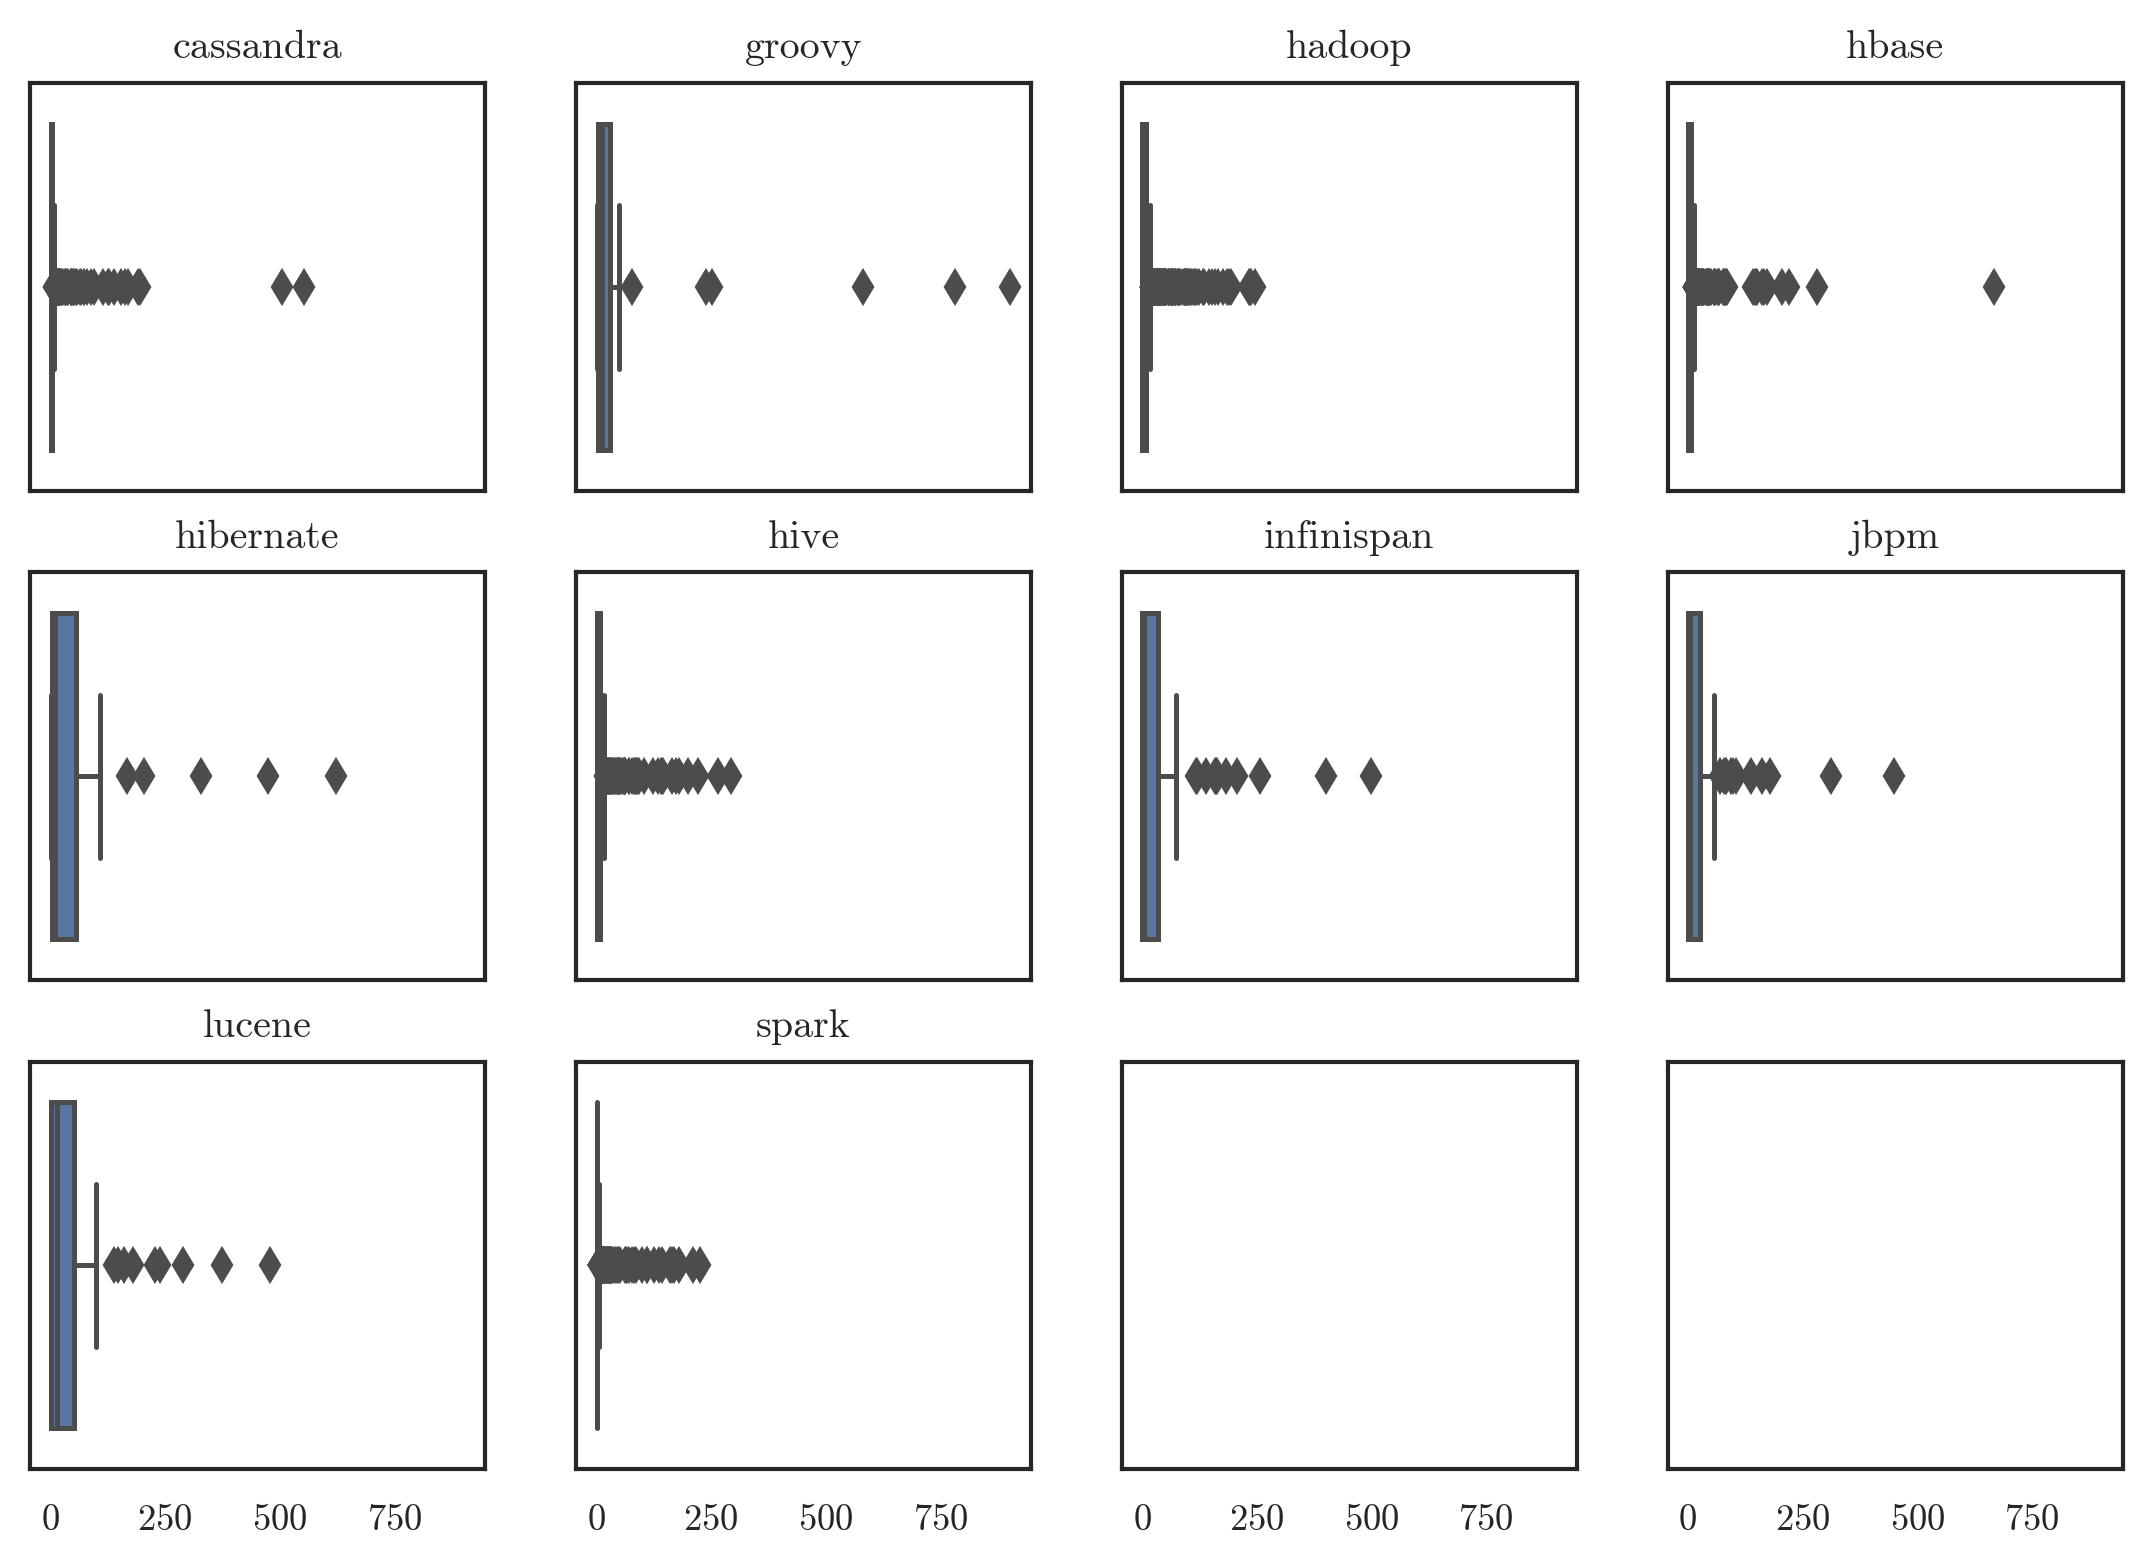

In [21]:
fig, ax = plt.subplots(3,4, figsize=(9,6), sharex=True, sharey=True)

for axi, cori in zip(ax.flatten(),target_counts):
    # sns.histplot(target_counts[cori], ax=axi, bins=15)
    sns.boxplot(target_counts[cori], ax=axi, orient='h')
    axi.set_title(cori)
    axi.set_ylabel("")
    axi.set_yticks([])
    

plt.show()

In [ ]:
from scipy import stats as st

[st.mode(np.array(list(target_counts[i].values()))) for i in target_counts]


In [ ]:
[target_counts[i].most_common(1)[0] for i in target_counts]


In [ ]:
fig = plt.figure(layout='constrained', figsize=(12, 8))

fig.suptitle('fig')

subfigs = fig.subfigures(3, 4, wspace=0.01)


for fi, cori in zip(subfigs.flatten(),target_counts):
    axi = fi.subplots(2,1, height_ratios=[2,1], sharex=True)
    axbox = axi[1]
    axhist = axi[0]
    # sns.stripplot(target_counts[cori], ax=axbox, orient='h', color='#AAAAAA')
    sns.stripplot(target_counts[cori].values(), ax=axbox, orient='h', s=2, alpha=.25, linewidth=1, marker="o")
    sns.histplot(target_counts[cori].values(), ax=axhist, bins=10, edgecolor='k',linewidth=1)
    


In [ ]:
fig, ax = plt.subplots(3,4, figsize=(12,6), sharex=True, sharey=True)

for axi, cori in zip(ax.flatten(),target_counts):
    # sns.histplot(target_counts[cori], ax=axi, bins=15)
    # sns.stripplot(target_counts[cori], ax=axi, orient='h', s=2, edgecolor='k', linewidth=1, alpha=.5, marker="x")
    sns.boxenplot(target_counts[cori], ax=axi, orient='h', )# edgecolor='k', linewidth=1, alpha=.5, marker="x")
    axi.set_title(cori)
    # axi.set_ylabel("")
    # axi.set_yticks([])
    

plt.show()

In [ ]:
sns.histplot(target_counts['groovy'])

In [ ]:
cor = filtered_csv['groovy']
cor.describe().rename(columns={'count_summary':'groovy'}).T

In [ ]:
counts = Counter(cor['assignee_username'])
counts.values()

In [ ]:
stat_df_t.columns

In [ ]:
n_targets = []
targetcount_mean = []
targetcount_median = []

i = 'cassandra'
f_df = filtered_csv[i]
f_df['count_summary'] = f_df['summary'].apply(lambda x: len(x.split(" ")))    
stat_df = f_df[['count_summary']].describe().rename(columns={'count_summary':i})
n_targets.append(f_df[['assignee_username']].nunique().values[0])
counts = Counter(f_df['assignee_username'])
targetcount_mean.append(statistics.mean(counts.values()))
targetcount_median.append(statistics.median(counts.values()))

for i in filtered_csv_list[1:]:
    f_df = filtered_csv[i]
    f_df['count_summary'] = f_df['summary'].apply(lambda x: len(x.split(" ")))    
    stat_df = pd.concat([stat_df, 
                         f_df[['count_summary']].describe().rename(columns={'count_summary':i})],
                       axis=1)
    
    n_targets.append(f_df[['assignee_username']].nunique().values[0])
    
    counts = Counter(f_df['assignee_username'])
    targetcount_mean.append(statistics.mean(counts.values()))
    targetcount_median.append(statistics.median(counts.values()))


stat_df_t = stat_df.T.copy()
stat_df_t = pd.concat([stat_df_t, 
                       pd.DataFrame(n_targets, index=stat_df_t.index, columns=['n_targets']),
                       pd.DataFrame(targetcount_mean, index=stat_df_t.index, columns=['targetcount_mean']),
                       pd.DataFrame(targetcount_median, index=stat_df_t.index, columns=['targetcount_median'])
                      ],
                      axis=1)

stat_df_t.round(3)

In [ ]:
stat_df_t.iloc[:,8:]

In [ ]:
# for i in filtered_csv_list:

# Use a string as an argument


In [ ]:
f_df